# Agentic RAG

In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
crewai 0.27.0 requires langchain<0.2.0,>=0.1.10, but you have langchain 0.2.12 which is incompatible.
crewai-tools 0.1.4 requires chromadb<0.5.0,>=0.4.22, but you have chromadb 0.5.5 which is incompatible.
crewai-tools 0.1.4 requires langchain<0.2.0,>=0.1.4, but you have langchain 0.2.12 which is incompatible.
embedchain 0.1.99 requires chromadb<0.5.0,>=0.4.17, but you have chromadb 0.5.5 which is incompatible.
embedchain 0.1.99 requires langchain<0.2.0,>=0.1.4, but you have langchain 0.2.12 which is incompatible.
embedchain 0.1.99 requires langchain-openai<0.0.6,>=0.0.5, but you have langchain-openai 0.1.20 which is incompatible.
embedchain 0.1.99 requires pypdf<4.0.0,>=3.11.0, but you have pypdf 4.2.0 which is incompatible.
embedchain 0.1.99 requires tiktoken<0.6.0,>=0.5.2, but you have tiktoken 0.7.0 which is i

In [1]:
import os
from langchain_openai import AzureOpenAI
from dotenv import dotenv_values

config = dotenv_values(".env") 


os.environ["AZURE_OPENAI_API_VERSION"] = dotenv_values(".env")["AZURE_OPENAI_API_VERSION"]
os.environ["AZURE_OPENAI_ENDPOINT"] = dotenv_values(".env")["AZURE_OPENAI_ENDPOINT"] 
os.environ["AZURE_OPENAI_API_KEY"] = dotenv_values(".env")["AZURE_OPENAI_API_KEY"]
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-4o"

from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI

model = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
)

message = HumanMessage(
    content="Translate this sentence from English to French. I love programming."
)
model.invoke([message])

AIMessage(content="J'aime programmer.", response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 19, 'total_tokens': 23, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_67802d9a6d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run-53cac4f8-fc7d-4d20-90f0-c9439e77a4fd-0', usage_metadata={'input_tokens': 19, 'output_tokens': 4, 'total_tokens': 23})

In [2]:
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-large"
)

# DB tool

In [3]:
import sqlite3
import pandas as pd

# Sample data from the CSV
data = {
    "Name": ["John Doe", "Jane Smith", "Alex Johnson", "Chris Lee", "Patricia Brown"],
    "Gender": ["Male", "Female", "Male", "Non-binary", "Female"],
    "Age": [28, 34, 22, 29, 41],
    "Previous Purchases": [
        "Pro Gear 123 Climbing Shoes, UltraClip Carabiner, StrongRope 500",
        "ClimbSafe Harness, GripMaster Chalk Bag, RockShield Helmet",
        "QuickClip Carabiner",
        "SummitX Climbing Shoes, ClimbSafe Harness",
        "StrongRope 500, ProGrip Chalk, SecureBelay Device, QuickLink Quickdraw Set"
    ],
    "Reviews Given": [
        "I really liked this product!",
        "The product quality is great, highly recommend!",
        "It's okay, but I expected better.",
        "Good value for the price.",
        "Excellent gear, will buy again!"
    ]
}

# Converting the dictionary to a DataFrame
df = pd.DataFrame(data)

# Connecting to a SQLite database (it will create a new one if it doesn't exist)
conn = sqlite3.connect('climbing_gear_customers.db')

# Storing the DataFrame in the SQLite database
df.to_sql('customer_interactions', conn, index=False, if_exists='replace')

# Committing and closing the connection
conn.commit()
conn.close()


In [3]:
from langchain_community.utilities.sql_database import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///climbing_gear_customers.db")

In [4]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=model)
toolkit.get_tools()

[QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x00000258F50D1A30>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x00000258F50D1A30>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x00000258F50D1A30>),
 QuerySQLCheckerTool(description='Use this tool to 

# FAISS

## Climbing products

In [5]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [6]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader
import time
from langchain_text_splitters import CharacterTextSplitter

file_path = (
    "Climbing product sheet.pdf"
)
loader = PyPDFLoader(file_path)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

vector_store.add_documents(documents=docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


['7b640933-a1ba-4d41-b6d7-143c5ca84fe8',
 '8d86579d-318d-4503-bfbd-8f53151d3d1a',
 '35945c1d-70b5-4408-bf26-a79489e21e74',
 'c0dd9df7-2651-4cd5-9a3e-1032a98bed35',
 'aec3f209-1f98-43d8-841f-ad81dfe5e383']

In [7]:
from langchain_community.retrievers import AzureAISearchRetriever

products_retriever = vector_store.as_retriever()

In [8]:
from langchain.tools.retriever import create_retriever_tool

climbing_products_tool = create_retriever_tool(
    products_retriever,
    "climbing_products_search",
    """
    Search and return information about climbing products.
    """
)

## trekking

In [9]:
from langchain.document_loaders import PyPDFDirectoryLoader


index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store_trekking = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

file_path = (
    "trekkings"
)
loader = PyPDFDirectoryLoader(file_path)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

In [10]:
vector_store_trekking.add_documents(documents=docs)

trekking_retriever = vector_store_trekking.as_retriever()

from langchain.tools.retriever import create_retriever_tool

trekking_tool = create_retriever_tool(
    trekking_retriever,
    "trekking_search",
    """
    Search and return information about trekkings in Nepal.
    """
)

In [11]:
tools = [climbing_products_tool, trekking_tool, toolkit.get_tools()[0], toolkit.get_tools()[1], toolkit.get_tools()[2], toolkit.get_tools()[3]]

In [12]:
tools

[Tool(name='climbing_products_search', description='\n    Search and return information about climbing products.\n    ', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x00000258F46E9440>, retriever=VectorStoreRetriever(tags=['FAISS', 'AzureOpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000258F1AA6C00>), document_prompt=PromptTemplate(input_variables=['page_content'], template='{page_content}'), document_separator='\n\n'), coroutine=functools.partial(<function _aget_relevant_documents at 0x00000258F4763420>, retriever=VectorStoreRetriever(tags=['FAISS', 'AzureOpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000258F1AA6C00>), document_prompt=PromptTemplate(input_variables=['page_content'], template='{page_content}'), document_separator='\n\n')),
 Tool(name='trekking_search', description='\n    Search and return informat

## Agent state

In [13]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## Nodes and Edges

In [14]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
import datetime


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            name = configuration.get("name", None)
            state = {**state, "user_info": name}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}




prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support for a climbing company. "
            "given customer's name, make sure to first query the db and then incorporate customer's information from the database. "
            " Use the provided tools to search for climbing gears and trekkings in Nepal, upon customer's request. "
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"

        ),
        ("placeholder", "{messages}"),
    ]
)


assistant_runnable = prompt | model.bind_tools(tools)

In [17]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

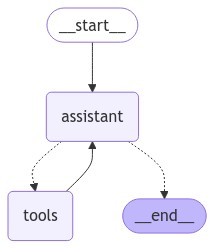

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [19]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, Can you help me find some climbing shoes based on my previous purchases?",
    "I want to do a trekking on the highest base camp in nepal, which trek would you recommend?",
]


thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "name": "John Doe",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hi there, Can you help me find some climbing shoes based on my previous purchases?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_R0RBtHiI0OzYdik7W9K6nbyx)
 Call ID: call_R0RBtHiI0OzYdik7W9K6nbyx
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

customer_interactions
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_TP2h17wsOjKwyIaajmYCKor7)
 Call ID: call_TP2h17wsOjKwyIaajmYCKor7
  Args:
    table_names: customer_interactions
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE customer_interactions (
	"Name" TEXT, 
	"Gender" TEXT, 
	"Age" INTEGER, 
	"Previous Purchases" TEXT, 
	"Reviews Given" TEXT
)

/*
3 rows from customer_interactions tabl